In [3]:
import os
import shutil

os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras.backend as K
K.set_image_dim_ordering('tf')
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *


import h5py

In [2]:
import os
import shutil

train_filenames = os.listdir('/home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('train2')
os.mkdir('train2/cat')
os.mkdir('train2/dog')

rmrf_mkdir('test2')
os.symlink('/home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test', 'test2/test')

for filename in train_cat:
    os.symlink('/home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/train/'+filename, 'train2/cat/'+filename)

for filename in train_dog:
    os.symlink('/home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/train/'+filename, 'train2/dog/'+filename)

In [9]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras.backend as K
K.set_image_dim_ordering('tf')
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)

    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("train2", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

    #my add starts
    train_filenames = train_generator.filenames
    train_nb_samples = len(train_filenames)

    test_filenames = test_generator.filenames
    test_nb_samples = len(test_filenames)
    
    #my add finish
    
    train = model.predict_generator(train_generator,steps=train_nb_samples)
    test = model.predict_generator(test_generator,steps=test_nb_samples)

                                   
    with h5py.File("gap_%s.h5"%MODEL.func_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

'''
write_gap(ResNet50, (224, 224))
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_gap(Xception, (299, 299), xception.preprocess_input)
'''


'\nwrite_gap(ResNet50, (224, 224))\nwrite_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)\nwrite_gap(Xception, (299, 299), xception.preprocess_input)\n'

In [4]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [5]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

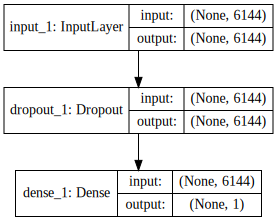

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 74s 4ms/step - loss: 0.0628 - acc: 0.9781 - val_loss: 0.0162 - val_acc: 0.9956
Epoch 2/8
20000/20000 [==============================] - 1s 42us/step - loss: 0.0228 - acc: 0.9925 - val_loss: 0.0139 - val_acc: 0.9950
Epoch 3/8
20000/20000 [==============================] - 1s 42us/step - loss: 0.0179 - acc: 0.9946 - val_loss: 0.0167 - val_acc: 0.9934
Epoch 4/8
20000/20000 [==============================] - 1s 42us/step - loss: 0.0171 - acc: 0.9946 - val_loss: 0.0107 - val_acc: 0.9960
Epoch 5/8
20000/20000 [==============================] - 1s 41us/step - loss: 0.0152 - acc: 0.9950 - val_loss: 0.0100 - val_acc: 0.9966
Epoch 6/8
20000/20000 [==============================] - 1s 42us/step - loss: 0.0133 - acc: 0.9955 - val_loss: 0.0096 - val_acc: 0.9968
Epoch 7/8
20000/20000 [==============================] - 1s 42us/step - loss: 0.0124 - acc: 0.9965 - val_loss: 0.0097 - val_acc: 0.9960

In [8]:
model.save('model.h5')

In [7]:
import glob

import re

file_list = sorted(glob.glob('test/test/*'),key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
i=1
a=list()
for file in file_list:
    i += 1
    print(i)
    img = image.load_img(file, target_size=(299, 299)) 
    # 图像预处理 
    x = image.img_to_array(img) 
    x = np.expand_dims(x, axis=0) 
    x = preprocess_input(x) 
    # 对图像进行分类 
    preds = model.predict(x)
    print(preds[0][0])
    a.append(preds[0])

print(a)

'''
    if preds[0][0] == 1:
        a.append([0.999])
    elif preds[0][0] == 0:
        a.append([0.001])
'''
    
    

2


NameError: name 'preprocess_input' is not defined

In [9]:
print("test")

test


In [ ]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

In [11]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

12500/12500 [==============================] - 0s 17us/step
Found 12500 images belonging to 1 classes.


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

In [5]:
import glob
glob.glob('test/test/*')

['test/test/9240.jpg',
 'test/test/4878.jpg',
 'test/test/12223.jpg',
 'test/test/8198.jpg',
 'test/test/8625.jpg',
 'test/test/11285.jpg',
 'test/test/248.jpg',
 'test/test/9479.jpg',
 'test/test/5011.jpg',
 'test/test/6282.jpg',
 'test/test/1758.jpg',
 'test/test/9483.jpg',
 'test/test/11914.jpg',
 'test/test/11802.jpg',
 'test/test/12411.jpg',
 'test/test/7756.jpg',
 'test/test/1295.jpg',
 'test/test/2590.jpg',
 'test/test/11616.jpg',
 'test/test/11839.jpg',
 'test/test/74.jpg',
 'test/test/377.jpg',
 'test/test/8760.jpg',
 'test/test/11976.jpg',
 'test/test/7091.jpg',
 'test/test/5829.jpg',
 'test/test/1878.jpg',
 'test/test/4739.jpg',
 'test/test/401.jpg',
 'test/test/8212.jpg',
 'test/test/217.jpg',
 'test/test/4302.jpg',
 'test/test/6670.jpg',
 'test/test/2373.jpg',
 'test/test/2655.jpg',
 'test/test/7863.jpg',
 'test/test/10918.jpg',
 'test/test/5013.jpg',
 'test/test/4686.jpg',
 'test/test/10434.jpg',
 'test/test/7798.jpg',
 'test/test/12357.jpg',
 'test/test/10982.jpg',
 'tes

In [9]:
file_list = glob.glob('test/test/*')

for file in file_list:
    print(file)

test/test/9240.jpg
test/test/4878.jpg
test/test/12223.jpg
test/test/8198.jpg
test/test/8625.jpg
test/test/11285.jpg
test/test/248.jpg
test/test/9479.jpg
test/test/5011.jpg
test/test/6282.jpg
test/test/1758.jpg
test/test/9483.jpg
test/test/11914.jpg
test/test/11802.jpg
test/test/12411.jpg
test/test/7756.jpg
test/test/1295.jpg
test/test/2590.jpg
test/test/11616.jpg
test/test/11839.jpg
test/test/74.jpg
test/test/377.jpg
test/test/8760.jpg
test/test/11976.jpg
test/test/7091.jpg
test/test/5829.jpg
test/test/1878.jpg
test/test/4739.jpg
test/test/401.jpg
test/test/8212.jpg
test/test/217.jpg
test/test/4302.jpg
test/test/6670.jpg
test/test/2373.jpg
test/test/2655.jpg
test/test/7863.jpg
test/test/10918.jpg
test/test/5013.jpg
test/test/4686.jpg
test/test/10434.jpg
test/test/7798.jpg
test/test/12357.jpg
test/test/10982.jpg
test/test/2208.jpg
test/test/3419.jpg
test/test/6026.jpg
test/test/1496.jpg
test/test/2720.jpg
test/test/10641.jpg
test/test/7674.jpg
test/test/12451.jpg
test/test/8389.jpg
test

test/test/5271.jpg
test/test/9194.jpg
test/test/3859.jpg
test/test/4275.jpg
test/test/7590.jpg
test/test/7232.jpg
test/test/11063.jpg
test/test/1898.jpg
test/test/5678.jpg
test/test/3945.jpg
test/test/3110.jpg
test/test/4401.jpg
test/test/3374.jpg
test/test/3785.jpg
test/test/7274.jpg
test/test/5508.jpg
test/test/4272.jpg
test/test/4703.jpg
test/test/7518.jpg
test/test/7702.jpg
test/test/8154.jpg
test/test/11518.jpg
test/test/8033.jpg
test/test/770.jpg
test/test/2950.jpg
test/test/7302.jpg
test/test/1399.jpg
test/test/5847.jpg
test/test/853.jpg
test/test/4344.jpg
test/test/157.jpg
test/test/9257.jpg
test/test/10274.jpg
test/test/8649.jpg
test/test/1206.jpg
test/test/10487.jpg
test/test/8177.jpg
test/test/7866.jpg
test/test/9845.jpg
test/test/4328.jpg
test/test/1147.jpg
test/test/9521.jpg
test/test/2196.jpg
test/test/9883.jpg
test/test/4437.jpg
test/test/3065.jpg
test/test/8609.jpg
test/test/3535.jpg
test/test/5711.jpg
test/test/12348.jpg
test/test/5646.jpg
test/test/3861.jpg
test/test/

test/test/11769.jpg
test/test/1876.jpg
test/test/1660.jpg
test/test/156.jpg
test/test/2327.jpg
test/test/11889.jpg
test/test/7273.jpg
test/test/8362.jpg
test/test/1641.jpg
test/test/7679.jpg
test/test/9307.jpg
test/test/1914.jpg
test/test/9646.jpg
test/test/9841.jpg
test/test/6365.jpg
test/test/2185.jpg
test/test/128.jpg
test/test/8794.jpg
test/test/9329.jpg
test/test/11625.jpg
test/test/11795.jpg
test/test/9282.jpg
test/test/7881.jpg
test/test/6115.jpg
test/test/5434.jpg
test/test/1512.jpg
test/test/12435.jpg
test/test/4849.jpg
test/test/6525.jpg
test/test/6881.jpg
test/test/2858.jpg
test/test/6373.jpg
test/test/779.jpg
test/test/11103.jpg
test/test/1617.jpg
test/test/2156.jpg
test/test/8460.jpg
test/test/2903.jpg
test/test/10763.jpg
test/test/1067.jpg
test/test/3045.jpg
test/test/12049.jpg
test/test/8093.jpg
test/test/9624.jpg
test/test/12021.jpg
test/test/7757.jpg
test/test/34.jpg
test/test/9545.jpg
test/test/2215.jpg
test/test/7454.jpg
test/test/2405.jpg
test/test/10260.jpg
test/te

test/test/556.jpg
test/test/3557.jpg
test/test/10676.jpg
test/test/10860.jpg
test/test/2949.jpg
test/test/4209.jpg
test/test/9246.jpg
test/test/11887.jpg
test/test/2745.jpg
test/test/10668.jpg
test/test/11466.jpg
test/test/2280.jpg
test/test/1633.jpg
test/test/10884.jpg
test/test/6861.jpg
test/test/2839.jpg
test/test/9138.jpg
test/test/5201.jpg
test/test/6428.jpg
test/test/4992.jpg
test/test/3507.jpg
test/test/9300.jpg
test/test/12249.jpg
test/test/9098.jpg
test/test/1759.jpg
test/test/11554.jpg
test/test/7543.jpg
test/test/4700.jpg
test/test/8077.jpg
test/test/4331.jpg
test/test/1468.jpg
test/test/6448.jpg
test/test/4704.jpg
test/test/9010.jpg
test/test/8315.jpg
test/test/10833.jpg
test/test/9860.jpg
test/test/4841.jpg
test/test/7027.jpg
test/test/10347.jpg
test/test/4976.jpg
test/test/4502.jpg
test/test/9612.jpg
test/test/6847.jpg
test/test/3464.jpg
test/test/12353.jpg
test/test/6147.jpg
test/test/3314.jpg
test/test/6766.jpg
test/test/3796.jpg
test/test/1702.jpg
test/test/10257.jpg
t

test/test/109.jpg
test/test/9719.jpg
test/test/3447.jpg
test/test/6186.jpg
test/test/11070.jpg
test/test/10072.jpg
test/test/9766.jpg
test/test/608.jpg
test/test/6164.jpg
test/test/12437.jpg
test/test/3369.jpg
test/test/5774.jpg
test/test/8854.jpg
test/test/4875.jpg
test/test/3545.jpg
test/test/11371.jpg
test/test/8592.jpg
test/test/5796.jpg
test/test/12122.jpg
test/test/7979.jpg
test/test/4788.jpg
test/test/5309.jpg
test/test/4765.jpg
test/test/9661.jpg
test/test/6593.jpg
test/test/270.jpg
test/test/5126.jpg
test/test/5366.jpg
test/test/7177.jpg
test/test/1519.jpg
test/test/9207.jpg
test/test/311.jpg
test/test/3595.jpg
test/test/11413.jpg
test/test/6839.jpg
test/test/1090.jpg
test/test/6382.jpg
test/test/2201.jpg
test/test/11420.jpg
test/test/11470.jpg
test/test/4543.jpg
test/test/9076.jpg
test/test/4658.jpg
test/test/6728.jpg
test/test/5275.jpg
test/test/10725.jpg
test/test/6843.jpg
test/test/909.jpg
test/test/3587.jpg
test/test/8322.jpg
test/test/4529.jpg
test/test/5294.jpg
test/tes

test/test/9764.jpg
test/test/10121.jpg
test/test/10619.jpg
test/test/10223.jpg
test/test/873.jpg
test/test/9645.jpg
test/test/10352.jpg
test/test/5403.jpg
test/test/8144.jpg
test/test/3027.jpg
test/test/1128.jpg
test/test/3368.jpg
test/test/7608.jpg
test/test/11623.jpg
test/test/11550.jpg
test/test/1045.jpg
test/test/11952.jpg
test/test/11547.jpg
test/test/7542.jpg
test/test/5195.jpg
test/test/2811.jpg
test/test/1347.jpg
test/test/10569.jpg
test/test/8300.jpg
test/test/3294.jpg
test/test/81.jpg
test/test/8273.jpg
test/test/2581.jpg
test/test/724.jpg
test/test/6836.jpg
test/test/7693.jpg
test/test/5041.jpg
test/test/2801.jpg
test/test/8011.jpg
test/test/10082.jpg
test/test/1424.jpg
test/test/6775.jpg
test/test/3000.jpg
test/test/9449.jpg
test/test/1319.jpg
test/test/6720.jpg
test/test/9355.jpg
test/test/5407.jpg
test/test/5254.jpg
test/test/6884.jpg
test/test/9366.jpg
test/test/11865.jpg
test/test/11689.jpg
test/test/4692.jpg
test/test/10349.jpg
test/test/4053.jpg
test/test/8391.jpg
tes

test/test/3677.jpg
test/test/10062.jpg
test/test/6128.jpg
test/test/9775.jpg
test/test/7697.jpg
test/test/6276.jpg
test/test/3117.jpg
test/test/2647.jpg
test/test/10292.jpg
test/test/8870.jpg
test/test/6522.jpg
test/test/6021.jpg
test/test/2336.jpg
test/test/3393.jpg
test/test/10110.jpg
test/test/9911.jpg
test/test/12070.jpg
test/test/2014.jpg
test/test/9650.jpg
test/test/11246.jpg
test/test/6925.jpg
test/test/12200.jpg
test/test/2865.jpg
test/test/6516.jpg
test/test/8000.jpg
test/test/1634.jpg
test/test/11454.jpg
test/test/6899.jpg
test/test/91.jpg
test/test/7535.jpg
test/test/3640.jpg
test/test/3475.jpg
test/test/880.jpg
test/test/4398.jpg
test/test/9258.jpg
test/test/4597.jpg
test/test/2003.jpg
test/test/10651.jpg
test/test/4631.jpg
test/test/3915.jpg
test/test/5190.jpg
test/test/10797.jpg
test/test/12169.jpg
test/test/3043.jpg
test/test/7229.jpg
test/test/5601.jpg
test/test/12137.jpg
test/test/11630.jpg
test/test/8302.jpg
test/test/6220.jpg
test/test/8886.jpg
test/test/4620.jpg
tes

test/test/3966.jpg
test/test/7160.jpg
test/test/9728.jpg
test/test/11515.jpg
test/test/3553.jpg
test/test/3800.jpg
test/test/492.jpg
test/test/7491.jpg
test/test/10025.jpg
test/test/6573.jpg
test/test/7122.jpg
test/test/12310.jpg
test/test/2877.jpg
test/test/1165.jpg
test/test/9567.jpg
test/test/3184.jpg
test/test/2123.jpg
test/test/5304.jpg
test/test/10069.jpg
test/test/4823.jpg
test/test/5912.jpg
test/test/7600.jpg
test/test/6665.jpg
test/test/5970.jpg
test/test/11975.jpg
test/test/9791.jpg
test/test/12493.jpg
test/test/5269.jpg
test/test/835.jpg
test/test/1882.jpg
test/test/6835.jpg
test/test/6032.jpg
test/test/976.jpg
test/test/7139.jpg
test/test/1205.jpg
test/test/4754.jpg
test/test/5480.jpg
test/test/10212.jpg
test/test/5758.jpg
test/test/2955.jpg
test/test/10197.jpg
test/test/10969.jpg
test/test/6389.jpg
test/test/6519.jpg
test/test/11669.jpg
test/test/7719.jpg
test/test/7949.jpg
test/test/90.jpg
test/test/1264.jpg
test/test/11542.jpg
test/test/666.jpg
test/test/5668.jpg
test/te

In [7]:
ls -ltr test

total 4
lrwxrwxrwx 1 ubuntu ubuntu 73 Aug  8 15:12 test -> /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/


In [2]:
ls -ltr test2/test/


total 303992
-rw-r--r-- 1 ubuntu ubuntu 22964 Sep 20  2013 9.jpg
-rw-r--r-- 1 ubuntu ubuntu 11559 Sep 20  2013 8.jpg
-rw-r--r-- 1 ubuntu ubuntu  7990 Sep 20  2013 7.jpg
-rw-r--r-- 1 ubuntu ubuntu 28002 Sep 20  2013 6.jpg
-rw-r--r-- 1 ubuntu ubuntu 19175 Sep 20  2013 5.jpg
-rw-r--r-- 1 ubuntu ubuntu 10177 Sep 20  2013 57.jpg
-rw-r--r-- 1 ubuntu ubuntu 28589 Sep 20  2013 56.jpg
-rw-r--r-- 1 ubuntu ubuntu 22857 Sep 20  2013 55.jpg
-rw-r--r-- 1 ubuntu ubuntu 29402 Sep 20  2013 54.jpg
-rw-r--r-- 1 ubuntu ubuntu 32723 Sep 20  2013 53.jpg
-rw-r--r-- 1 ubuntu ubuntu 18015 Sep 20  2013 52.jpg
-rw-r--r-- 1 ubuntu ubuntu 36701 Sep 20  2013 51.jpg
-rw-r--r-- 1 ubuntu ubuntu 13349 Sep 20  2013 50.jpg
-rw-r--r-- 1 ubuntu ubuntu 34554 Sep 20  2013 4.jpg
-rw-r--r-- 1 ubuntu ubuntu 20535 Sep 20  2013 49.jpg
-rw-r--r-- 1 ubuntu ubuntu 21511 Sep 20  2013 48.jpg
-rw-r--r-- 1 ubuntu ubuntu 17703 Sep 20  2013 47.jpg
-rw-r--r-- 1 ubuntu ubuntu  1305 Sep 20  2013 46.jpg
-rw-r--r-- 1 ubuntu ubuntu 21194 Sep 20

-rw-r--r-- 1 ubuntu ubuntu 27319 Sep 20  2013 2026.jpg
-rw-r--r-- 1 ubuntu ubuntu 17263 Sep 20  2013 2025.jpg
-rw-r--r-- 1 ubuntu ubuntu 15210 Sep 20  2013 2024.jpg
-rw-r--r-- 1 ubuntu ubuntu 21057 Sep 20  2013 2023.jpg
-rw-r--r-- 1 ubuntu ubuntu 15269 Sep 20  2013 2022.jpg
-rw-r--r-- 1 ubuntu ubuntu 10237 Sep 20  2013 2021.jpg
-rw-r--r-- 1 ubuntu ubuntu 21852 Sep 20  2013 2020.jpg
-rw-r--r-- 1 ubuntu ubuntu 18307 Sep 20  2013 2019.jpg
-rw-r--r-- 1 ubuntu ubuntu 25402 Sep 20  2013 2018.jpg
-rw-r--r-- 1 ubuntu ubuntu 19349 Sep 20  2013 2017.jpg
-rw-r--r-- 1 ubuntu ubuntu 18764 Sep 20  2013 2016.jpg
-rw-r--r-- 1 ubuntu ubuntu 22824 Sep 20  2013 2015.jpg
-rw-r--r-- 1 ubuntu ubuntu 17802 Sep 20  2013 2014.jpg
-rw-r--r-- 1 ubuntu ubuntu 18571 Sep 20  2013 2137.jpg
-rw-r--r-- 1 ubuntu ubuntu 14753 Sep 20  2013 2136.jpg
-rw-r--r-- 1 ubuntu ubuntu 51372 Sep 20  2013 2135.jpg
-rw-r--r-- 1 ubuntu ubuntu 37092 Sep 20  2013 2134.jpg
-rw-r--r-- 1 ubuntu ubuntu 19724 Sep 20  2013 2133.jpg
-rw-r--r--

-rw-r--r-- 1 ubuntu ubuntu 22339 Sep 20  2013 6008.jpg
-rw-r--r-- 1 ubuntu ubuntu 26713 Sep 20  2013 6007.jpg
-rw-r--r-- 1 ubuntu ubuntu 22839 Sep 20  2013 6006.jpg
-rw-r--r-- 1 ubuntu ubuntu 28724 Sep 20  2013 6005.jpg
-rw-r--r-- 1 ubuntu ubuntu 24757 Sep 20  2013 6004.jpg
-rw-r--r-- 1 ubuntu ubuntu 35738 Sep 20  2013 6003.jpg
-rw-r--r-- 1 ubuntu ubuntu 48973 Sep 20  2013 6002.jpg
-rw-r--r-- 1 ubuntu ubuntu 25610 Sep 20  2013 6001.jpg
-rw-r--r-- 1 ubuntu ubuntu 34872 Sep 20  2013 6000.jpg
-rw-r--r-- 1 ubuntu ubuntu 22633 Sep 20  2013 5999.jpg
-rw-r--r-- 1 ubuntu ubuntu 18043 Sep 20  2013 5998.jpg
-rw-r--r-- 1 ubuntu ubuntu 15974 Sep 20  2013 5997.jpg
-rw-r--r-- 1 ubuntu ubuntu 42068 Sep 20  2013 5996.jpg
-rw-r--r-- 1 ubuntu ubuntu 18533 Sep 20  2013 5995.jpg
-rw-r--r-- 1 ubuntu ubuntu 18836 Sep 20  2013 5994.jpg
-rw-r--r-- 1 ubuntu ubuntu 28001 Sep 20  2013 5993.jpg
-rw-r--r-- 1 ubuntu ubuntu 12837 Sep 20  2013 5992.jpg
-rw-r--r-- 1 ubuntu ubuntu 29676 Sep 20  2013 5991.jpg
-rw-r--r--

-rw-r--r-- 1 ubuntu ubuntu 10223 Sep 20  2013 11335.jpg
-rw-r--r-- 1 ubuntu ubuntu 36103 Sep 20  2013 11334.jpg
-rw-r--r-- 1 ubuntu ubuntu 24567 Sep 20  2013 11333.jpg
-rw-r--r-- 1 ubuntu ubuntu  5415 Sep 20  2013 11332.jpg
-rw-r--r-- 1 ubuntu ubuntu  4995 Sep 20  2013 11331.jpg
-rw-r--r-- 1 ubuntu ubuntu 12522 Sep 20  2013 11330.jpg
-rw-r--r-- 1 ubuntu ubuntu 26570 Sep 20  2013 11329.jpg
-rw-r--r-- 1 ubuntu ubuntu 12404 Sep 20  2013 11328.jpg
-rw-r--r-- 1 ubuntu ubuntu 25716 Sep 20  2013 11327.jpg
-rw-r--r-- 1 ubuntu ubuntu 18850 Sep 20  2013 11326.jpg
-rw-r--r-- 1 ubuntu ubuntu 25747 Sep 20  2013 11325.jpg
-rw-r--r-- 1 ubuntu ubuntu 14146 Sep 20  2013 11324.jpg
-rw-r--r-- 1 ubuntu ubuntu 28742 Sep 20  2013 11439.jpg
-rw-r--r-- 1 ubuntu ubuntu 26960 Sep 20  2013 11438.jpg
-rw-r--r-- 1 ubuntu ubuntu 11424 Sep 20  2013 11437.jpg
-rw-r--r-- 1 ubuntu ubuntu 23188 Sep 20  2013 11436.jpg
-rw-r--r-- 1 ubuntu ubuntu 20169 Sep 20  2013 11435.jpg
-rw-r--r-- 1 ubuntu ubuntu 21812 Sep 20  2013 11

In [13]:
print("test")

test


In [ ]:
~/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py in evaluate_generator(model, generator, steps, max_queue_size, workers, use_multiprocessing, verbose)
    322                                  '(x, y, sample_weight) '
    323                                  'or (x, y). Found: ' +
--> 324                                  str(generator_output))
    325             outs = model.test_on_batch(x, y, sample_weight=sample_weight)
    326             if not isinstance(outs, list):

ValueError: Output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: [[[[-0.69411767 -0.654902   -0.6862745 ]

In [4]:
import glob

file_list = glob.glob('test/test/*')
print(file_list)

['test/test/9240.jpg', 'test/test/4878.jpg', 'test/test/12223.jpg', 'test/test/8198.jpg', 'test/test/8625.jpg', 'test/test/11285.jpg', 'test/test/248.jpg', 'test/test/9479.jpg', 'test/test/5011.jpg', 'test/test/6282.jpg', 'test/test/1758.jpg', 'test/test/9483.jpg', 'test/test/11914.jpg', 'test/test/11802.jpg', 'test/test/12411.jpg', 'test/test/7756.jpg', 'test/test/1295.jpg', 'test/test/2590.jpg', 'test/test/11616.jpg', 'test/test/11839.jpg', 'test/test/74.jpg', 'test/test/377.jpg', 'test/test/8760.jpg', 'test/test/11976.jpg', 'test/test/7091.jpg', 'test/test/5829.jpg', 'test/test/1878.jpg', 'test/test/4739.jpg', 'test/test/401.jpg', 'test/test/8212.jpg', 'test/test/217.jpg', 'test/test/4302.jpg', 'test/test/6670.jpg', 'test/test/2373.jpg', 'test/test/2655.jpg', 'test/test/7863.jpg', 'test/test/10918.jpg', 'test/test/5013.jpg', 'test/test/4686.jpg', 'test/test/10434.jpg', 'test/test/7798.jpg', 'test/test/12357.jpg', 'test/test/10982.jpg', 'test/test/2208.jpg', 'test/test/3419.jpg', 'te

In [5]:
ls -ltr /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/*

-rw-r--r-- 1 ubuntu ubuntu 22964 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/9.jpg
-rw-r--r-- 1 ubuntu ubuntu 11559 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/8.jpg
-rw-r--r-- 1 ubuntu ubuntu  7990 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/7.jpg
-rw-r--r-- 1 ubuntu ubuntu 28002 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/6.jpg
-rw-r--r-- 1 ubuntu ubuntu 19175 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/5.jpg
-rw-r--r-- 1 ubuntu ubuntu 10177 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/57.jpg
-rw-r--r-- 1 ubuntu ubuntu 28589 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/56.jpg
-rw-r--r-- 1 ubuntu ubuntu 22857 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/t

-rw-r--r-- 1 ubuntu ubuntu 36523 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/1318.jpg
-rw-r--r-- 1 ubuntu ubuntu 26175 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/1317.jpg
-rw-r--r-- 1 ubuntu ubuntu 23667 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/1316.jpg
-rw-r--r-- 1 ubuntu ubuntu 46229 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/1315.jpg
-rw-r--r-- 1 ubuntu ubuntu 20596 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/1314.jpg
-rw-r--r-- 1 ubuntu ubuntu 20476 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/1313.jpg
-rw-r--r-- 1 ubuntu ubuntu 12614 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/1312.jpg
-rw-r--r-- 1 ubuntu ubuntu  9397 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redu

-rw-r--r-- 1 ubuntu ubuntu 22648 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/3823.jpg
-rw-r--r-- 1 ubuntu ubuntu 19963 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/3822.jpg
-rw-r--r-- 1 ubuntu ubuntu 41587 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/3821.jpg
-rw-r--r-- 1 ubuntu ubuntu 20463 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/3820.jpg
-rw-r--r-- 1 ubuntu ubuntu 30203 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/3819.jpg
-rw-r--r-- 1 ubuntu ubuntu  4247 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/3818.jpg
-rw-r--r-- 1 ubuntu ubuntu 21994 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/3817.jpg
-rw-r--r-- 1 ubuntu ubuntu 19409 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redu

-rw-r--r-- 1 ubuntu ubuntu  3802 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/6392.jpg
-rw-r--r-- 1 ubuntu ubuntu 21616 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/6391.jpg
-rw-r--r-- 1 ubuntu ubuntu 27695 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/6390.jpg
-rw-r--r-- 1 ubuntu ubuntu 18704 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/6389.jpg
-rw-r--r-- 1 ubuntu ubuntu  2597 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/6388.jpg
-rw-r--r-- 1 ubuntu ubuntu 33909 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/6387.jpg
-rw-r--r-- 1 ubuntu ubuntu 31476 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/6386.jpg
-rw-r--r-- 1 ubuntu ubuntu 15604 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redu

-rw-r--r-- 1 ubuntu ubuntu 28618 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/8748.jpg
-rw-r--r-- 1 ubuntu ubuntu 13446 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/8747.jpg
-rw-r--r-- 1 ubuntu ubuntu 50162 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/8746.jpg
-rw-r--r-- 1 ubuntu ubuntu 19196 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/8745.jpg
-rw-r--r-- 1 ubuntu ubuntu 28603 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/8744.jpg
-rw-r--r-- 1 ubuntu ubuntu  6303 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/8743.jpg
-rw-r--r-- 1 ubuntu ubuntu 23842 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/8742.jpg
-rw-r--r-- 1 ubuntu ubuntu 22615 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redu

-rw-r--r-- 1 ubuntu ubuntu 22644 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/11188.jpg
-rw-r--r-- 1 ubuntu ubuntu  7986 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/11187.jpg
-rw-r--r-- 1 ubuntu ubuntu 26232 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/11186.jpg
-rw-r--r-- 1 ubuntu ubuntu 23770 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/11185.jpg
-rw-r--r-- 1 ubuntu ubuntu 18434 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/11184.jpg
-rw-r--r-- 1 ubuntu ubuntu 19600 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/11183.jpg
-rw-r--r-- 1 ubuntu ubuntu 18113 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-cats-redux-kernels-edition/test/11182.jpg
-rw-r--r-- 1 ubuntu ubuntu 19712 Sep 20  2013 /home/ubuntu/.kaggle/competitions/dogs-vs-ca

In [11]:
import sys
from PIL import Image
sys.modules['Image'] = Image


from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

img = image.load_img('test/test/9240.jpg')
img.show()

ModuleNotFoundError: No module named 'keras'

In [13]:
cat sample_submission.csv

id,label
1,0.5
2,0.5
3,0.5
4,0.5
5,0.5
6,0.5
7,0.5
8,0.5
9,0.5
10,0.5
11,0.5
12,0.5
13,0.5
14,0.5
15,0.5
16,0.5
17,0.5
18,0.5
19,0.5
20,0.5
21,0.5
22,0.5
23,0.5
24,0.5
25,0.5
26,0.5
27,0.5
28,0.5
29,0.5
30,0.5
31,0.5
32,0.5
33,0.5
34,0.5
35,0.5
36,0.5
37,0.5
38,0.5
39,0.5
40,0.5
41,0.5
42,0.5
43,0.5
44,0.5
45,0.5
46,0.5
47,0.5
48,0.5
49,0.5
50,0.5
51,0.5
52,0.5
53,0.5
54,0.5
55,0.5
56,0.5
57,0.5
58,0.5
59,0.5
60,0.5
61,0.5
62,0.5
63,0.5
64,0.5
65,0.5
66,0.5
67,0.5
68,0.5
69,0.5
70,0.5
71,0.5
72,0.5
73,0.5
74,0.5
75,0.5
76,0.5
77,0.5
78,0.5
79,0.5
80,0.5
81,0.5
82,0.5
83,0.5
84,0.5
85,0.5
86,0.5
87,0.5
88,0.5
89,0.5
90,0.5
91,0.5
92,0.5
93,0.5
94,0.5
95,0.5
96,0.5
97,0.5
98,0.5
99,0.5
100,0.5
101,0.5
102,0.5
103,0.5
104,0.5
105,0.5
106,0.5
107,0.5
108,0.5
109,0.5
110,0.5
111,0.5
112,0.5
113,0.5
114,0.5
115,0.5
116,0.5
117,0.5
118,0.5
119,0.5
120,0.5
121,0.5
122,0.5
123,0.5
124,0.5
125,0.5
126,0.5
127,0.5
128,0.5
129,0.5
130,0.5
131,0.5
132,0.5
133,0.5
134,0.5
135,0.5
136,0.5
137,0.5
138

In [20]:
import re

file_list = sorted(glob.glob('test/test/*'),key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

In [19]:
print(file_list)

['test/test/1.jpg', 'test/test/2.jpg', 'test/test/3.jpg', 'test/test/4.jpg', 'test/test/5.jpg', 'test/test/6.jpg', 'test/test/7.jpg', 'test/test/8.jpg', 'test/test/9.jpg', 'test/test/10.jpg', 'test/test/11.jpg', 'test/test/12.jpg', 'test/test/13.jpg', 'test/test/14.jpg', 'test/test/15.jpg', 'test/test/16.jpg', 'test/test/17.jpg', 'test/test/18.jpg', 'test/test/19.jpg', 'test/test/20.jpg', 'test/test/21.jpg', 'test/test/22.jpg', 'test/test/23.jpg', 'test/test/24.jpg', 'test/test/25.jpg', 'test/test/26.jpg', 'test/test/27.jpg', 'test/test/28.jpg', 'test/test/29.jpg', 'test/test/30.jpg', 'test/test/31.jpg', 'test/test/32.jpg', 'test/test/33.jpg', 'test/test/34.jpg', 'test/test/35.jpg', 'test/test/36.jpg', 'test/test/37.jpg', 'test/test/38.jpg', 'test/test/39.jpg', 'test/test/40.jpg', 'test/test/41.jpg', 'test/test/42.jpg', 'test/test/43.jpg', 'test/test/44.jpg', 'test/test/45.jpg', 'test/test/46.jpg', 'test/test/47.jpg', 'test/test/48.jpg', 'test/test/49.jpg', 'test/test/50.jpg', 'test/te

In [21]:
rm test_result.csv

In [22]:
ls -ltr test_result.csv

ls: cannot access 'test_result.csv': No such file or directory


JASON’S CV
PERSONAL INFORMATION
Name/Gender: Jason Huang/Male			Birth & Phone: 1987/03/28 & 15167188892
Degree/School: Bachelor/Lishui University 	Major: Electronic Information Engineering
PROFESSION SKILLS
Soft Skill 	Hard Skill 
✓8 years IT support experience in GIB trading/risk system.
✓ Familiar with investment banking systems and trade life cycle process.
✓ Advanced language skills in English & Chinese	✓ Rich experience in developing automation using Python, Shell.
✓ Skilled use of Java, SQL, JavaScript, VBA, Swift, HTML5/CSS, Markup
✓ Familiar with machine learning and data science, R language
CERTIFICATION & TRAINING
Machine Learning - entry level	Udacity	Certificate Holder
Machine Learning - advanced	Udacity	Candidate
SCJP 	JAVA	Certificate Holder
OCP 	Oracle	Candidate
EDUCATION & EMPLOYMENT HISTORY
❖ Nomura Shanghai (information Tech Ltd)	Feb 2017 - Now
Role: Production Support Shared Services.
❖ Citi (Citi financial service Ltd)	Jun 2014 - Jan 2017
Role: Production support for Derivative/Cash trade processing system.
Description: Onboard new project APAC Derivative Support from SG to SH, give training to fellow team members, support for both Cash/Derivative environment for APAC users.
❖ HSBC(Guangzhou Software service Ltd)	Jan 2013 - June 2014
Role: L2 support for Foreign Exchange trading system.
Description: Off-shore Production support for HSBC FX-trading systems, take ownership in one of the critical FO trading system FX-Connect and support users from HK users.
❖ SSS/Capgemini (Deutsche Bank Contractor)	Sep 2010 - Jan 2013
Role: Shift leader, TEST environment support for BO settlement system.
Description: Coaching new joiners to familiar with the support process and environment, responsible to cover all required support work during working shift, responsible to help maintain and improve the systems of the Deutsche bank BO settlement testing environment. 
❖ EPRO Tech(Huawei contractor)	Jul 2010 - Sep 2010
Role: Java developer, participate in Cloud Computing system.
Description: Joining the work of developing and testing the component of Huawei Cloud Computing System, take training on Virtual machine and Cloud computing.
❖ Tarena Tech	Jul 2009 - Jun 2010
Role/Desc: Intern Java Developer, participate in Dangdang book-shopping website(Java,SSH).
❖ Lishui University	Jul 2006 - Jun 2010
Role: Student; Graduation Project: Developing a simple BBS web site (Java, SSH, MySQL).
DEVELOPMENT/PROJECT EXPERIENCE

Project Name: CSI project & Process Manager (SSS/Capgemini Sep 2010 - Jan 2013)
Project description (Group Project):
Maintain existing support tools using shell/java to send business critical reports with fellow teammates, maintain and developing automation tools using Shell to automatically detect process status and doing health check based on critical processes with fellow teammates.
Project Name: GENEOS monitoring implementation (HSBC Jan 2013 - June 2014)
Project description (Solo project):
Participate in developing back ground scripts to implement backend scripts to allow GENEOS to call it to do restarts or gather backend information like space usage, log monitoring, etc.
Project Name: Github – FreeCodeCamp(Self learned in 2015)
Project description (Solo project): 
Build News page, Profile page, random quote page, using HTML5/CSS JS.
URL: https://codepen.io/Sexyrabbit/pen/EyKveq
URL: https://codepen.io/Sexyrabbit/pen/NrpmKO
URL: https://codepen.io/Sexyrabbit/pen/vKyZYm

Project Name: Nomura Automation (2017~Now)
Project name: SIMM automation (SIMM is a business critical report)
Description: Using VBA, AUTOSYS restful API to automatically get SIMM batch status for all regions, and automatically calculate ETA for unfinished batches, it is scheduled in AUTOSYS and run every weekday to send status email to the team.
Project name: EOS health check/UMD browser health check
Description: Using Python, to send http request to automatically login system and do health check on HTML content.
Project name: Maintain existing Excel automation
Description: Maintain current Excel based report automation and fix some bugs that causing the report generation failure.
Project name: CPI data visualization report
Description: Extract Autosys/System performance statistics data for UDW and do visualization report.
Project Name: Machine Learning Namo dgree(Basic & Advanced) (2017~Now)
Project name: Statistics Basics – Analyze Stroop effect
Using the test data to form a statistics report using learned Statistics knowledge
Project name: Programing – Develop a movie website
Using Python/HTML5 to create a simple movie website
Project name: Linear Algebra – Linear regression
Using given data to form a report and achieve linear regression and data visualization.
Project name: Basic Data analysis 
Using Pandas/Numpy and data from Kaggle to form a report of Titanic passenger data.
Project name: Data modeling and predicting
Using learned data modeling skills to predict Boston housing price.
Project name: Machine learning – Predict Boston housing price
Using python sklearn to develop a machine learning project to predict Boston housing Prices
Project name: Machine learning – Predict survivor list from Titanic
Using python sklearn to develop a machine learning project to predict survivor list from Titanic catastrophe.
Project name: Supervised learning – Predicting donner 
Using learned Supervise learning knowledge to develop and predict possible charity donners from given user data.
Project name: Unsupervised learning – Enron scandal
Using unsupervised learning to classify categories from Enron scandal emails data from kaggle.
Project name: Reinforcement learning – Robot maze
Using unsupervised learning to deveop a robot that can walk out a random maze.
Project name: Deep learning – Predict dog breeds
Using CNN and transfer learning to predict dog breeds
Project name: Computer vision – Dog VS Cats
Using CNN and transfer learning to combine models like ResNet,VGG,GoogleNet etc to predict Dog/Cats data and meet the minimum requirement of scoring at least first 20 % of Kaggle competition.

REWARDS AND HIGHLIGHTS:
(Citi, team wise) A glaxy of Thanks	    2016 May
This is to send special thanks for my contribution to the team.(From TL)
(Capgemini, unit wise) Star performer	2012 July
This is to send thanks to my contributions to the team on automations and hard work.(From TL)
 (Capgemini, company wise)Capgemini GEM award	 2012 May
This is to send thanks to my contributions to give UNIX training to new joiners and interns. (From Unit manager/TL)
